In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [3]:
IMG_SIZE = (224, 224)   # Standard for CNNs
BATCH_SIZE = 32


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [5]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)


In [6]:
TRAIN_PATH = "../dataset/PlantVillage/train"
VAL_PATH   = "../dataset/PlantVillage/val"

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [7]:
images, labels = next(train_generator)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 38)


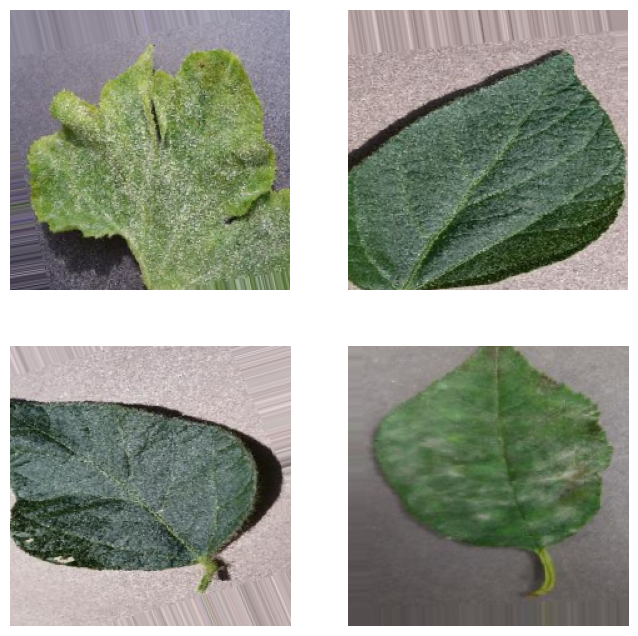

In [8]:
plt.figure(figsize=(8,8))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.show()


In [9]:
import os

os.makedirs("../models", exist_ok=True)


Defining CNN architecture


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])


In [11]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "../models/cnn_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


TRAINING THE MODEL 

In [13]:
import os

save_path = os.path.abspath("../models/cnn_model.h5")
print("Model will be saved at:\n", save_path)


Model will be saved at:
 c:\Crop Disease Detection\models\cnn_model.h5


In [15]:
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/25


   5/1358 [..............................] - ETA: 25:49 - loss: 24.2263 - accuracy: 0.1500

KeyboardInterrupt: 

In [14]:
from tensorflow.keras.models import load_model

scratch_model = load_model("../models/cnn_model.h5")
scratch_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

MbilenetV2---IMPROVING THE MODEL'S ACCURACY FROM 50% TO ALMOST 90% USING MOBILENETV2


In [15]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [16]:
TRAIN_PATH = "../dataset/PlantVillage/train"
VAL_PATH   = "../dataset/PlantVillage/val"

os.makedirs("../models", exist_ok=True)


In [17]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [19]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Freeze pretrained layers


In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [22]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [23]:
checkpoint = ModelCheckpoint(
    "../models/mobilenetv2_crop_disease.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [24]:
EPOCHS = 15

history_tl = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/15


1358/1358 [==============================] - ETA: 0s - loss: 1.7803 - accuracy: 0.5348
Epoch 1: val_accuracy improved from -inf to 0.81733, saving model to ../models\mobilenetv2_crop_disease.h5


c:\Crop Disease Detection\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 1172s 861ms/step - loss: 1.7803 - accuracy: 0.5348 - val_loss: 0.7587 - val_accuracy: 0.8173
Epoch 2/15
1358/1358 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.7519
Epoch 2: val_accuracy improved from 0.81733 to 0.87349, saving model to ../models\mobilenetv2_crop_disease.h5
1358/1358 [==============================] - 697s 514ms/step - loss: 0.8750 - accuracy: 0.7519 - val_loss: 0.4847 - val_accuracy: 0.8735
Epoch 3/15
1358/1358 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.8085
Epoch 3: val_accuracy improved from 0.87349 to 0.90056, saving model to ../models\mobilenetv2_crop_disease.h5
1358/1358 [==============================] - 688s 507ms/step - loss: 0.6544 - accuracy: 0.8085 - val_loss: 0.3700 - val_accuracy: 0.9006
Epoch 4/15
1358/1358 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8370
Epoch 4: val_accuracy improved from 0.90056 to 0.91179, saving model to ..

In [33]:
def format_label(label):
    label = label.replace("___", " - ")
    label = label.replace("_", " ")
    return label


1/1 [==============================] - 0s 47ms/step


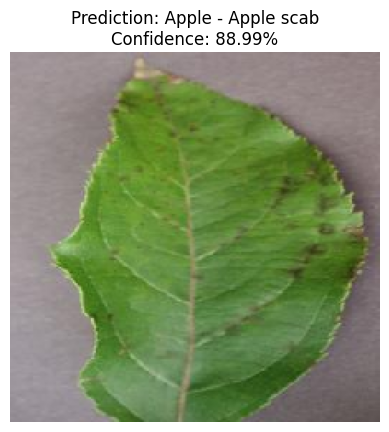

In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = r"C:\Crop Disease Detection\dataset\PlantVillage\train\Apple___Apple_scab\0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)

class_names = list(train_generator.class_indices.keys())
raw_label = class_names[np.argmax(pred)]
confidence = np.max(pred) * 100

pretty_label = format_label(raw_label)

plt.imshow(img)
plt.title(f"Prediction: {pretty_label}\nConfidence: {confidence:.2f}%")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 260ms/step


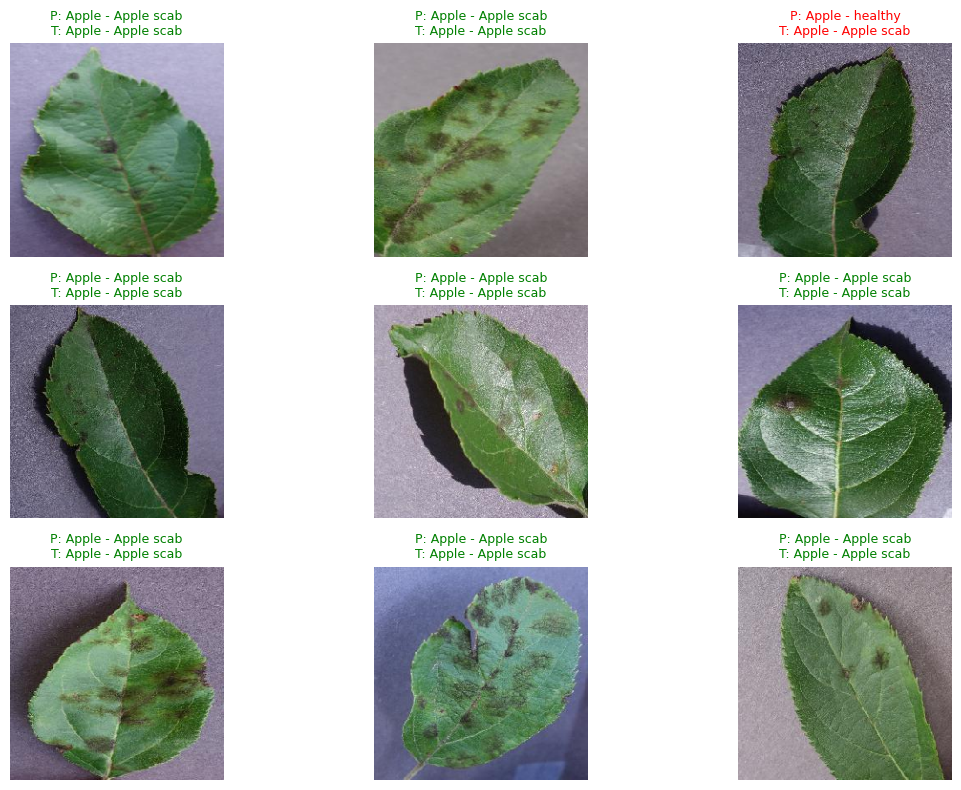

In [35]:
images, labels = next(val_generator)
preds = model.predict(images)

plt.figure(figsize=(12,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])

    true_label = format_label(
        list(train_generator.class_indices.keys())[np.argmax(labels[i])]
    )
    pred_label = format_label(
        list(train_generator.class_indices.keys())[np.argmax(preds[i])]
    )

    color = "green" if true_label == pred_label else "red"

    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


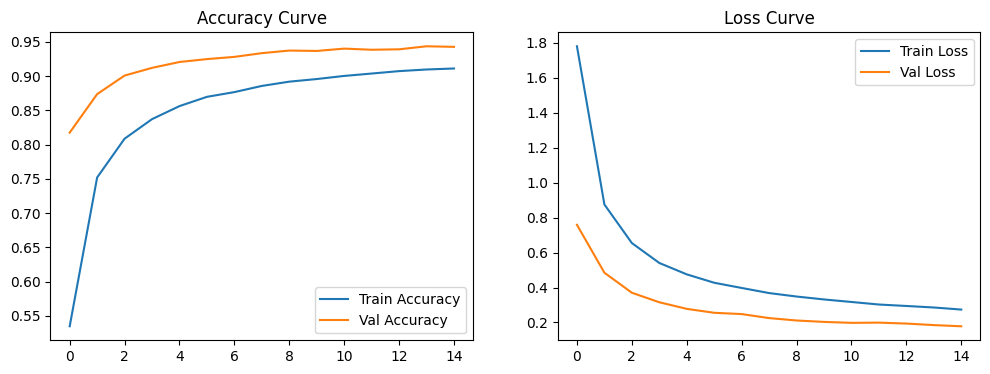

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_tl.history['accuracy'], label='Train Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

# Loss
plt.subplot(1,2,2)
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.show()


340/340 [==============================] - 186s 547ms/step


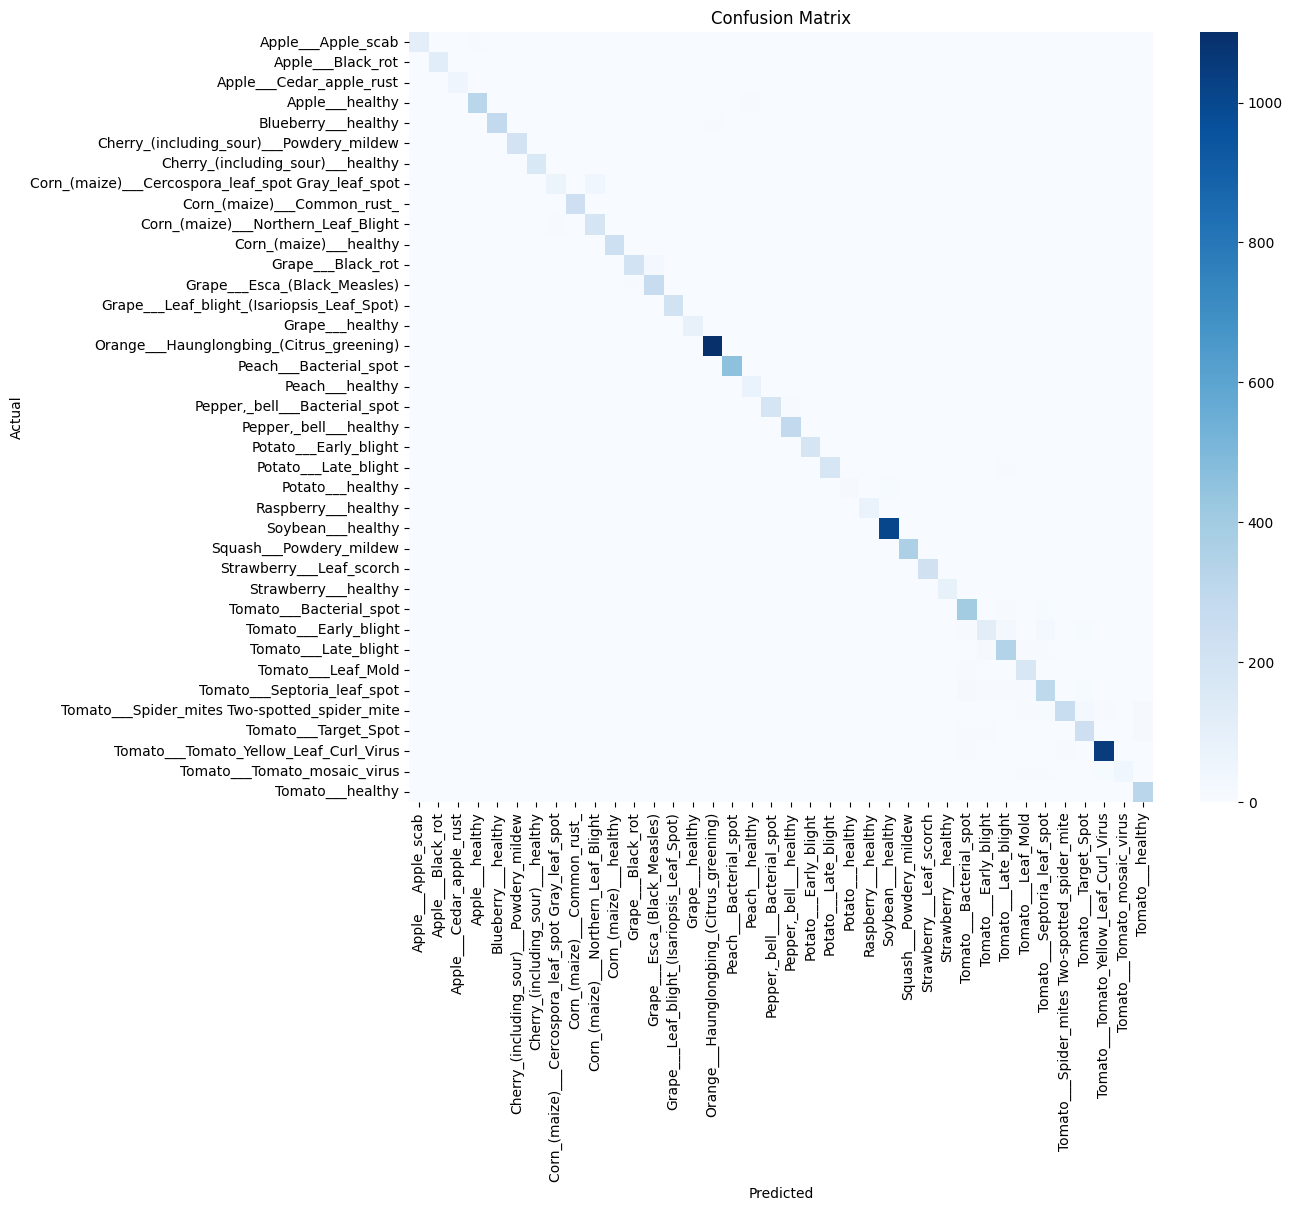

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on entire validation set
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


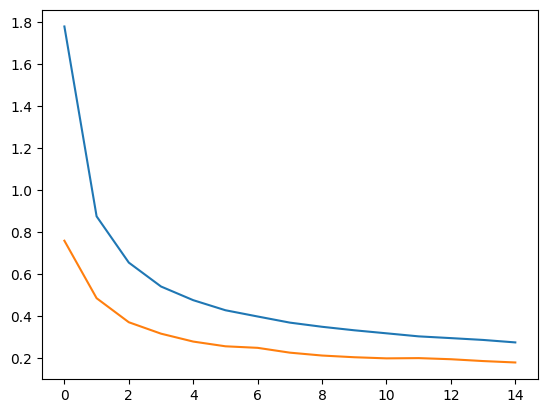

In [36]:
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
